In [1]:
%load_ext autoreload
%autoreload 

In [2]:

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time

os.chdir('/home/ali/packages/s2p-lbm/')

import suite2p

In [146]:
from suite3d import plot_utils as plot

In [3]:
from pathlib import Path

In [23]:
raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-16_1-2-3-4/raw2'

In [24]:
save_path = Path('/mnt/md0/runs/s2p-SS003_2024-08-16_1-2-3-4/')

In [25]:
ops = suite2p.default_ops()
ops['look_one_level_down'] = True
ops['subfolders'] = []
ops['nplanes'] = 7
ops['fs'] = 8.92
ops['batch_size'] = 400
ops['threshold_scaling'] = 0.5
ops['tau'] = 1.3
ops['nonrigid'] = False
ops['ignore_flyback'] = []
ops['data_path'] = [raw_data_path]
ops['save_path0'] = str(save_path)
# print(ops)
ops['do_registration'] = 2

In [326]:
imgdir = Path('/home/ali/packages/s2p-lbm/runs/Suite3D')

In [26]:
%%time
output_ops = suite2p.run_s2p(ops=ops)

{}
tif
** Found 20 tifs - converting to binary **
time 16.55 sec. Wrote 2000 frames per binary for 7 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: Applying builtin classifier at /home/ali/anaconda3/envs/s2p/lib/python3.9/site-packages/suite2p/classifiers/classifier.npy
----------- REGISTRATION
Reference frame, 5.28 sec.
Registered 400/2000 in 0.97s
Registered 800/2000 in 1.93s
Registered 1200/2000 in 2.91s
Registered 1600/2000 in 3.89s
Registered 2000/2000 in 4.87s
----------- Total 18.84 sec
Registration metrics, 14.60 sec.
----------- ROI DETECTION
Binning movie in chunks of length 12
Binned movie of size [166,592,547] created in 1.19 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 2.50 
0 ROIs, score=44.45
1000 ROIs, score=5.38
2000 ROIs, score=4.06
3000 ROIs, score=3.74
4000 ROIs, score=3.40
Detected 5000 ROIs, 9.98 sec
After r

In [358]:
all_ops = []
all_stats = []
Fs = []
spks = []
iscell = []
for plane in n.arange(ops['nplanes']):
    planedir = (save_path / 'suite2p' / f'plane{plane}')
    statx = planedir / 'stat.npy'
    opx = planedir / 'ops.npy'
    Fsx = planedir / 'F.npy'
    spksx = planedir / 'spks.npy'
    iscellx = planedir / 'iscell.npy'
    
    all_stats.append(n.load(statx, allow_pickle=True))
    all_ops.append(n.load(opx, allow_pickle=True).item())
    Fs.append(n.load(Fsx))
    spks.append(n.load(spksx))
    iscell.append(n.load(iscellx))

iscell = n.concatenate(iscell).astype(bool)

mean_img = n.stack([op['refImg'] for op in all_ops])
# corr_map = n.stack([op['Vcorr'] for op in all_ops])

nz = mean_img.shape[0]
Fs = n.concatenate(Fs)[iscell[:,0]]
spks = n.concatenate(spks)[iscell[:,0]]

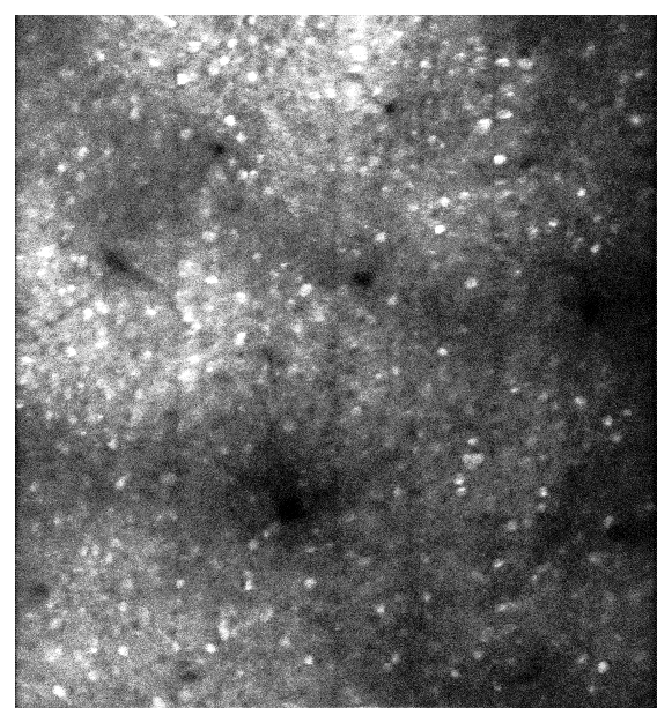

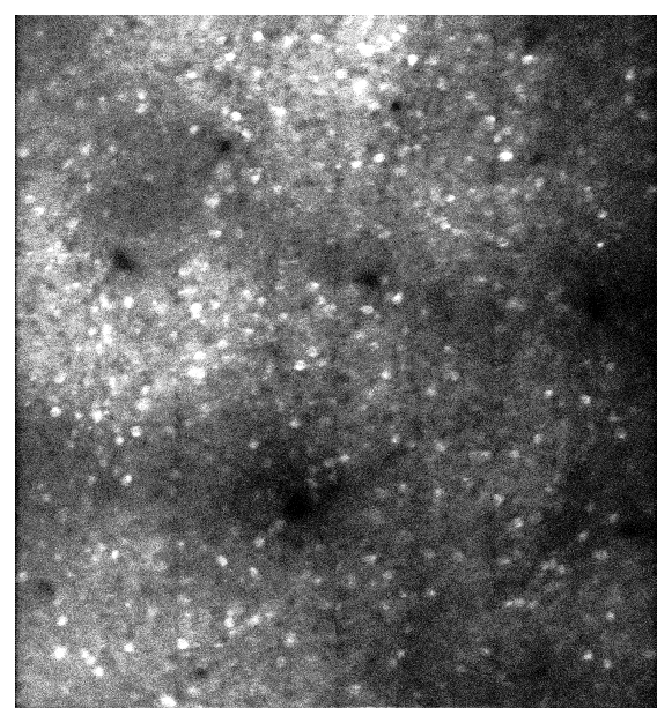

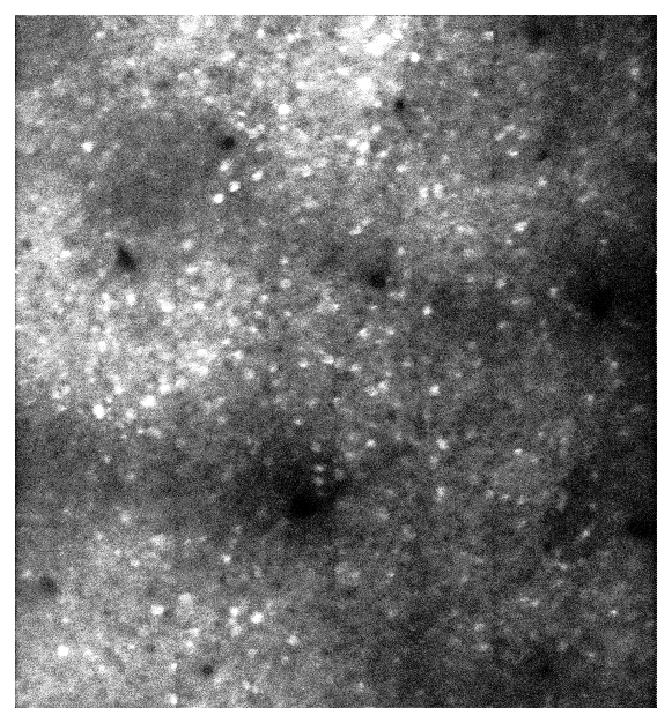

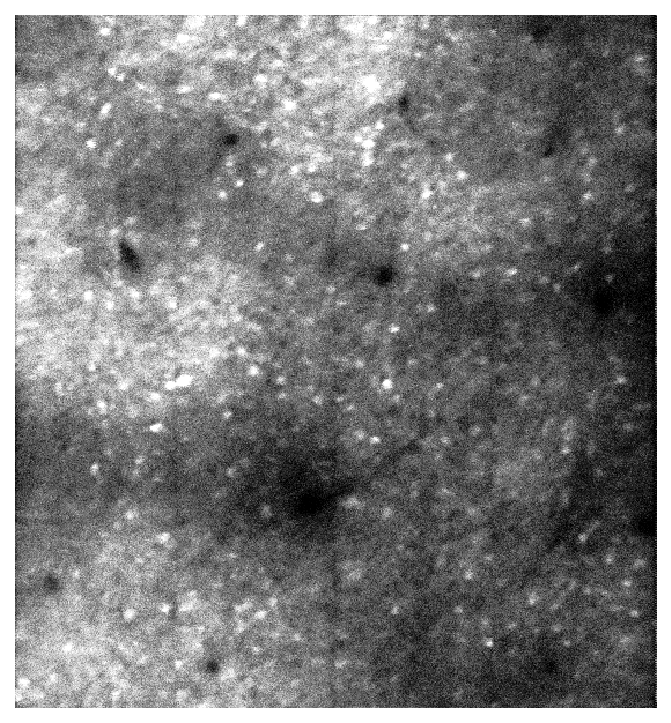

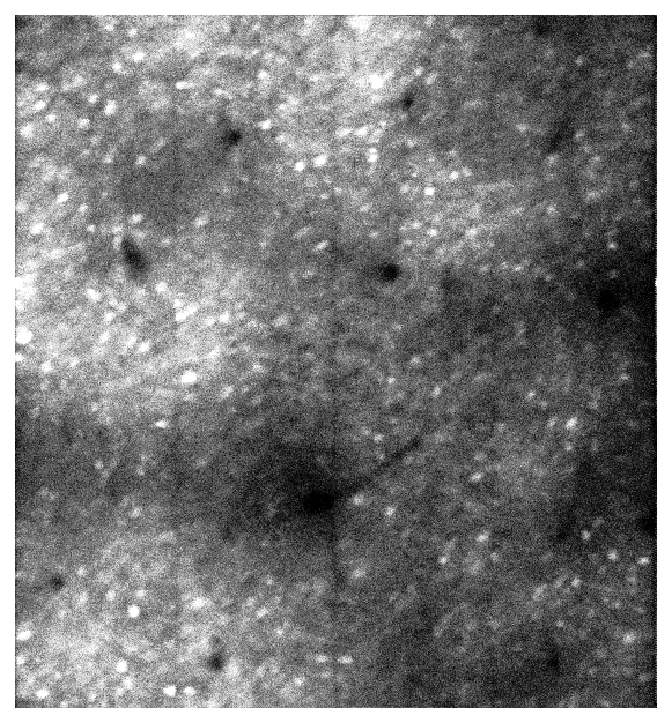

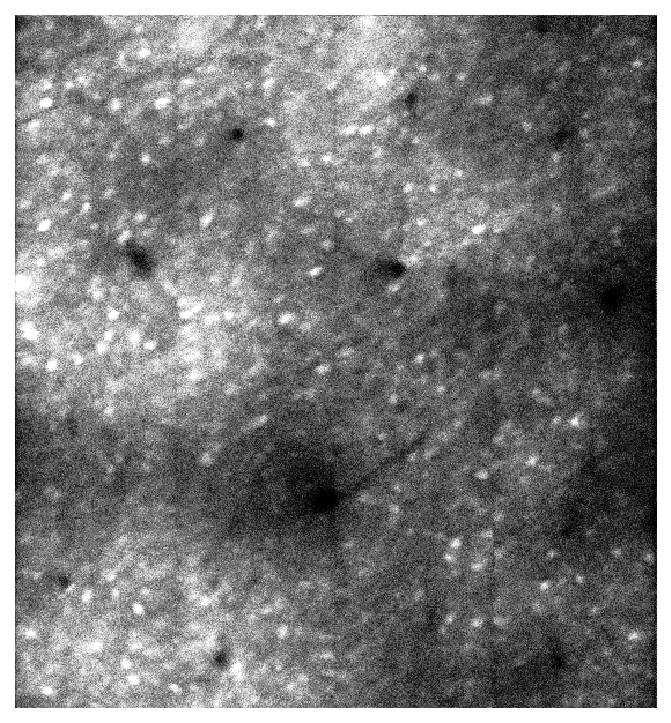

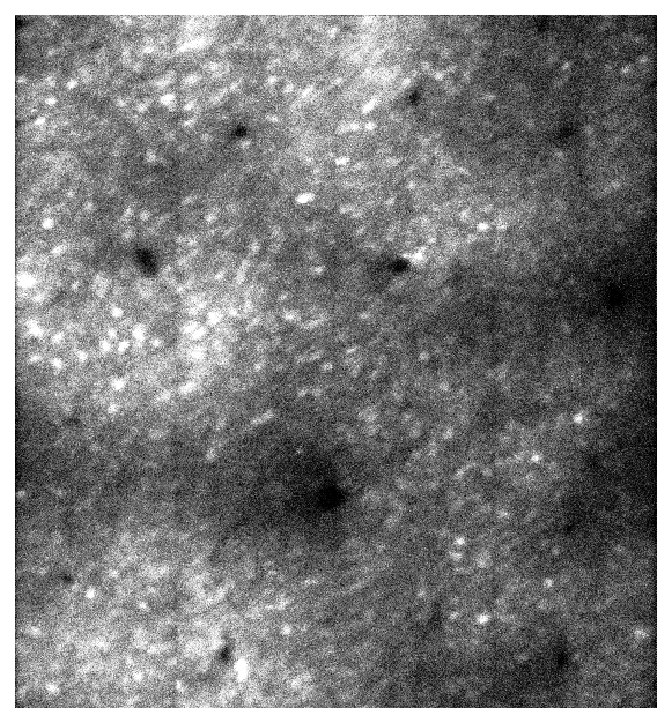

In [336]:
for i in range(nz):
    plot.show_img(mean_img[i])

In [338]:
xshifts = []
yshifts = []
for op in all_ops:
    xshifts.append(op['xoff'])
    yshifts.append(op['yoff'])
xshifts = n.array(xshifts)
yshifts = n.array(yshifts)

metrics_dir ='/mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/registered_fused_data'
metric_files = []
for file in os.listdir(metrics_dir):
    if 'metrics' in file:
        metric_files.append(file)
metric_files = n.sort(metric_files)
all_metrics = {}
for file in metric_files:
    metric = n.load(os.path.join(metrics_dir,file), allow_pickle=True).item()
    for k in metric.keys():
        if k not in all_metrics:
            all_metrics[k] = []
        all_metrics[k].append(metric[k])
        
for k in all_metrics.keys():
    all_metrics[k] = n.stack(all_metrics[k])
    # all_metrics.append(metric)

Text(0.5, 1.0, 'Corr. Coef. of x-shifts')

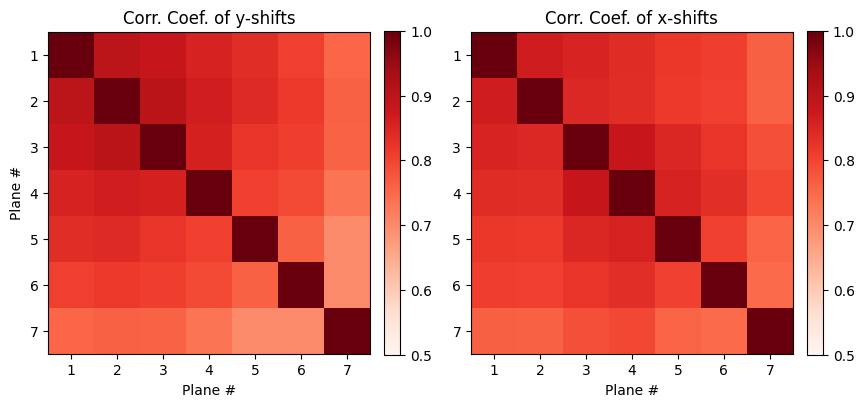

In [339]:
xcormat = n.corrcoef(xshifts)#, xshifts)
ycormat = n.corrcoef(yshifts)#, yshifts)

f,axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
ax = axs[0]
im = ax.imshow(xcormat,cmap='Reds', vmin=0.5, vmax=1)
# plt.colorbar()
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_xlabel("Plane #")
ax.set_ylabel("Plane #")
ax.set_title("Corr. Coef. of y-shifts")

ax = axs[1]
im = ax.imshow(ycormat, cmap='Reds', vmin=0.5, vmax=1)
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_xlabel("Plane #")
ax.set_title("Corr. Coef. of x-shifts")

In [ ]:
xshift_zmean = xshifts - xshifts.mean(axis=1, keepdims=True)
yshift_zmean = yshifts - yshifts.mean(axis=1, keepdims=True)

xdiff_all =  (xshift_zmean[:,n.newaxis] - xshift_zmean[n.newaxis])
xerr = (n.abs(xdiff_all)**2).mean(axis=-1) 
ydiff_all =  (yshift_zmean[:,n.newaxis] - yshift_zmean[n.newaxis])
yerr = (n.abs(ydiff_all)**2).mean(axis=-1) 


xydiff_all = n.sqrt(xdiff_all**2 + ydiff_all**2)

nz = xshift_zmean.shape[0]

Text(0.5, 1.0, 'Mean squared diff of x-shifts')

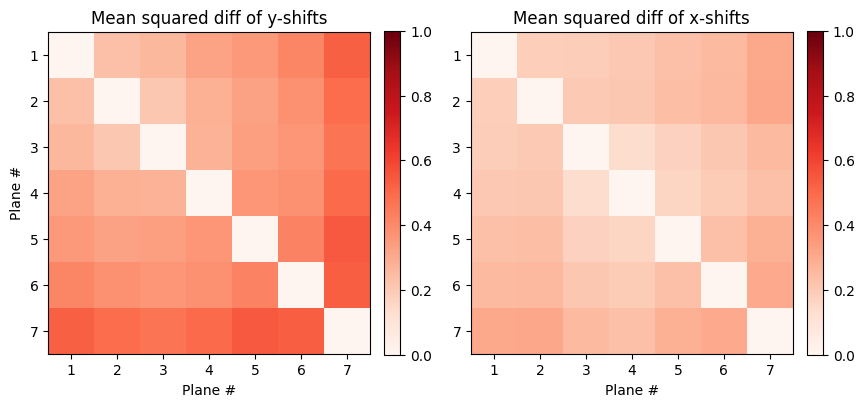

In [344]:
xcormat = n.corrcoef(xshifts)#, xshifts)
ycormat = n.corrcoef(yshifts)#, yshifts)

f,axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
ax = axs[0]
im = ax.imshow(xerr,cmap='Reds', vmin=0.0, vmax=1)
# plt.colorbar()
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_xlabel("Plane #")
ax.set_ylabel("Plane #")
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_title("Mean squared diff of y-shifts")

ax = axs[1]
im = ax.imshow(yerr, cmap='Reds', vmin=0.0, vmax=1)
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_xlabel("Plane #")
ax.set_title("Mean squared diff of x-shifts")

In [ ]:
noise_levels = all_metrics['noise_levels'].mean(axis=(0,2))
signal_to_background_ratio = all_metrics['signal_to_background_ratio'].mean(axis=0)
plane_stds = all_metrics['volume_std'].mean(axis=0)
signal_ranges = all_metrics['signal_range'].mean(axis=0)

sbr_mat = (signal_to_background_ratio[n.newaxis] + signal_to_background_ratio[:,n.newaxis])/2
shn_mat = (noise_levels[n.newaxis] + noise_levels[:,n.newaxis])/2
std_mat = (plane_stds[n.newaxis] + plane_stds[:,n.newaxis])/2
rng_mat = (signal_ranges[n.newaxis] + signal_ranges[:,n.newaxis])/2


In [362]:
from importlib import reload

Text(0.5, 0, 'Signal Range')

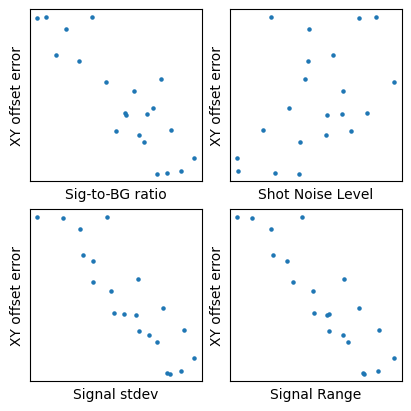

In [363]:
ylabel = 'XY offset error'
f,axs = plt.subplots(2,2, layout='constrained', figsize=(4,4))
ax = axs[0][0]
ax.scatter(plot.flatten_lower_tri(sbr_mat), plot.flatten_lower_tri(0.5*(yerr + xerr)), s = 5)
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.set_xlabel('Sig-to-BG ratio')
ax = axs[0][1]
ax.scatter(plot.flatten_lower_tri(shn_mat), plot.flatten_lower_tri(0.5*(yerr + xerr)), s = 5)
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.set_xlabel('Shot Noise Level')
ax = axs[1][0]
ax.scatter(plot.flatten_lower_tri(std_mat), plot.flatten_lower_tri(0.5*(yerr + xerr)), s = 5)
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.set_xlabel('Signal stdev')
ax = axs[1][1]
ax.scatter(plot.flatten_lower_tri(rng_mat), plot.flatten_lower_tri(0.5*(yerr + xerr)), s = 5)
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.set_xlabel('Signal Range')

In [ ]:
# difference between plane x and the mean of all planes other than x at each time
devs = n.abs(n.array([xshift_zmean[idx] -  xshift_zmean[n.where(n.arange(xshift_zmean.shape[0]) != idx)[0]].mean(axis=0) \
                                  for idx in range(xshift_zmean.shape[0])]))

# frames where each plane has 

plt.hist(devs[0], bins=n.linspace(0,2,11), alpha=0.5, log=True)
plt.hist(devs[-1], bins=n.linspace(0,2,11), alpha=0.5, log=True)

In [241]:
xydiff_all.shape

(7, 7, 2000)

In [135]:
xerr.shape

(7, 7)

In [134]:
xdiff_all.shape

(7, 7, 2000)